In [1]:
import pandas as pd
from tqdm import tqdm

# pre_experiment = pd.read_csv('data/experiments/experiments_mode.csv')
pre_experiment = None

columns = ['model_name', 'desire', 'num_sample', 'loss',
           'age_group_error', 'income_group_error', 'household_size_error', 'vehicles_error', 'family_structure_error', 'mean_error',
           'age_group_kl', 'income_group_kl', 'household_size_kl', 'vehicles_kl', 'family_structure_kl', 'mean_kl',
           'best_params']

In [2]:
desire = 'Eat'
choice_type = 'mode'
seed = 42

In [3]:
def run_baseline_mode(model_name, model_class):
    df = pd.DataFrame(columns=columns)
    for num_sample in tqdm(range(1, 11)):
        num_sample = num_sample * 2000
        model = model_class(data_dir='baseline/data',
                            desire=desire, sample_num=num_sample, seed=seed)
        if pre_experiment is not None:
            best_params = pre_experiment[(pre_experiment.model_name == model_name) & (
                pre_experiment.desire == desire) & (pre_experiment.num_sample == num_sample)].best_params.values[0]
            best_params = eval(best_params)
        else:
            best_params = None

        train_dataset, test_dataset, mapping = model.load_dataset()
        model.train_dataset = train_dataset[train_dataset['age_group'] != 'Teen']
        model.test_dataset = test_dataset[test_dataset['age_group'] != 'Teen']

        model.prepare_data(choice_type)

        if best_params is None:
            model.optimize()
        else:
            model.best_params = best_params

        model.train(model.best_params)
        loss, error, kl_divergence = model.evaluate_with_cv(choice_type)

        results = {
            "model_name": model_name,
            "desire": desire,
            "num_sample": num_sample,
            "loss": loss,
        }
        for key in ['age_group', 'income_group', 'household_size', 'vehicles', 'family_structure', 'mean']:
            results[key + '_error'] = error[key]
            results[key + '_kl'] = kl_divergence[key]
        results['best_params'] = model.best_params
        df.loc[len(df)] = results
    return df

In [4]:
def run_proposed_model(model_name, model_class):
    df = pd.DataFrame(columns=columns)
    for num_sample in range(0, 11):
        num_sample = num_sample * 2000
        choice_model = model_class(
            data_dir='data', desire=desire, sample_num=num_sample, skip_init=True, seed=seed)
        log_path = choice_model.log_data_path
        test_path = choice_model.test_data_path
        data = choice_model._read_log_data(log_path, test_path)
        data = data[data['age_group'] != 'Teen']
        loss, error, kl_divergence = choice_model._evaluate_with_cv(
            data, choice_type, cv=None, figsize=(20, 3), order=None, plot=False)
        results = {
            "model_name": model_name,
            "desire": desire,
            "num_sample": num_sample,
            "loss": loss,
        }
        for key in ['age_group', 'income_group', 'household_size', 'vehicles', 'family_structure', 'mean']:
            results[key + '_error'] = error[key]
            results[key + '_kl'] = kl_divergence[key]
        df.loc[len(df)] = results
    return df

# RandomForest


In [5]:
from baseline.models.random_forest import RandomForest

model_name = 'randomforest'

rf_df = run_baseline_mode(model_name, RandomForest)
rf_df.head()

100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


,model_name,desire,num_sample,loss,age_group_error,income_group_error,household_size_error,vehicles_error,family_structure_error,mean_error,age_group_kl,income_group_kl,household_size_kl,vehicles_kl,family_structure_kl,mean_kl,best_params
0,randomforest,Eat,2000,1.005296,0.136567,0.139099,0.108871,0.127852,0.103687,0.123215,0.163445,0.136223,0.075567,0.476430,0.068333,0.184000,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
1,randomforest,Eat,4000,1.010509,0.144022,0.138223,0.121243,0.150676,0.123280,0.135489,0.150922,0.136820,0.084812,0.524135,0.106115,0.200561,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
2,randomforest,Eat,6000,1.003678,0.161083,0.144089,0.122008,0.147013,0.125639,0.139966,0.157263,0.126765,0.098620,0.554457,0.116904,0.210802,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
3,randomforest,Eat,8000,1.003238,0.155510,0.128901,0.123225,0.144697,0.125295,0.135526,0.149501,0.108639,0.110363,0.551330,0.112037,0.206374,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
4,randomforest,Eat,10000,0.993663,0.173174,0.142131,0.134920,0.162916,0.138410,0.150310,0.185413,0.137374,0.123014,0.195371,0.151252,0.158485,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."


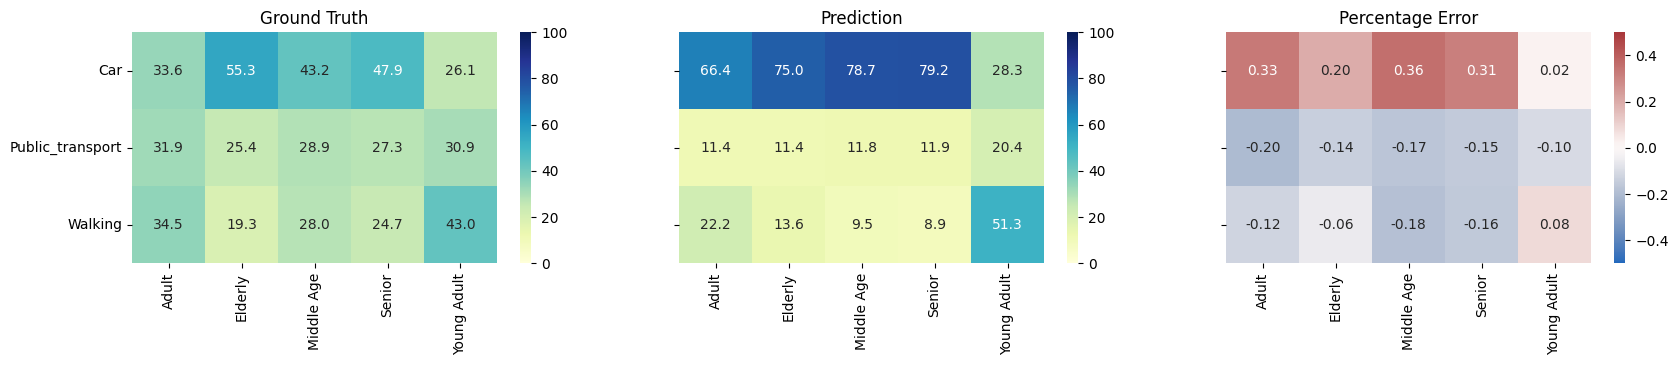

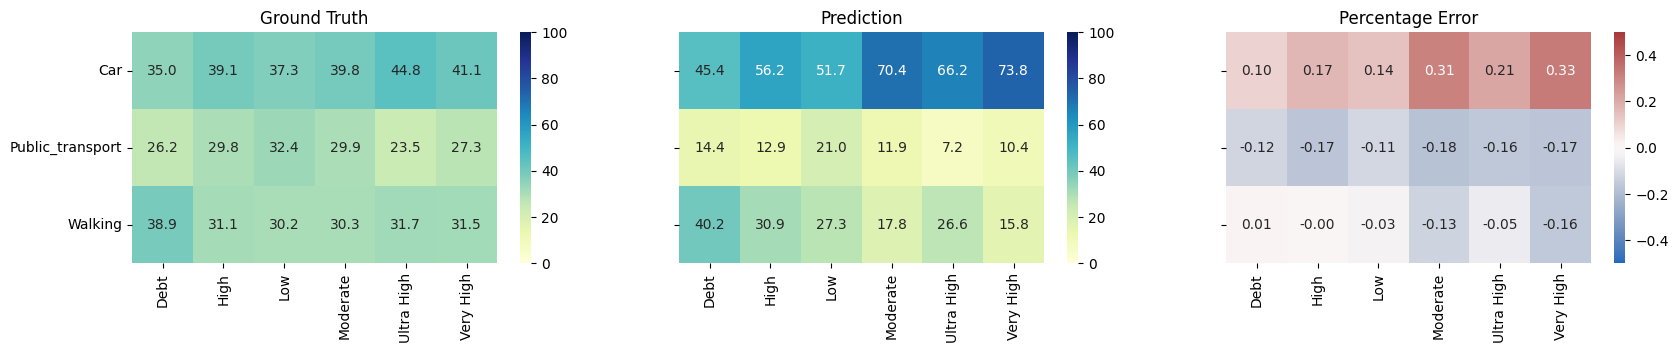

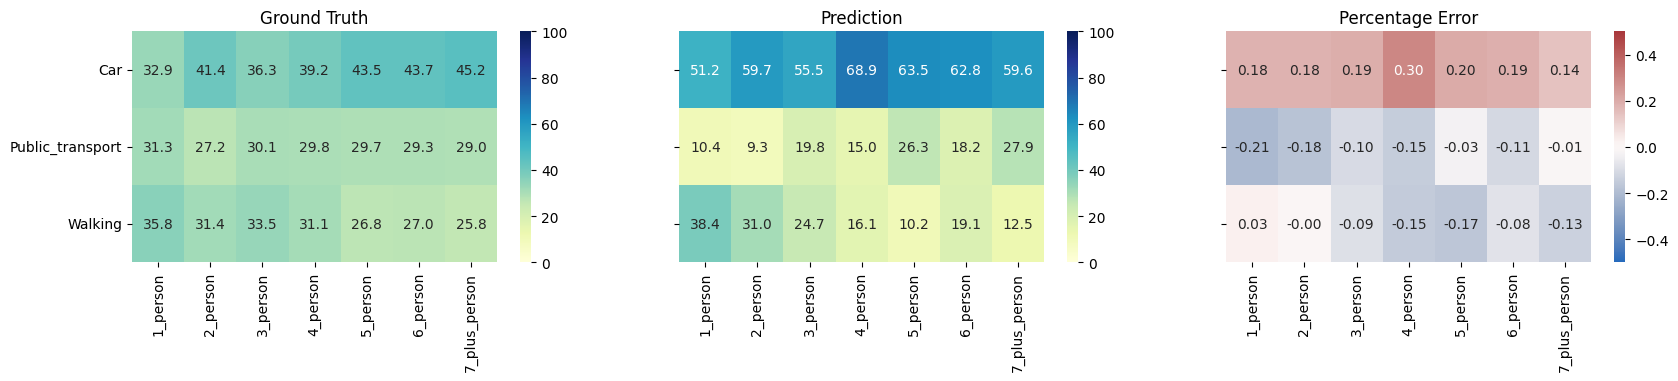

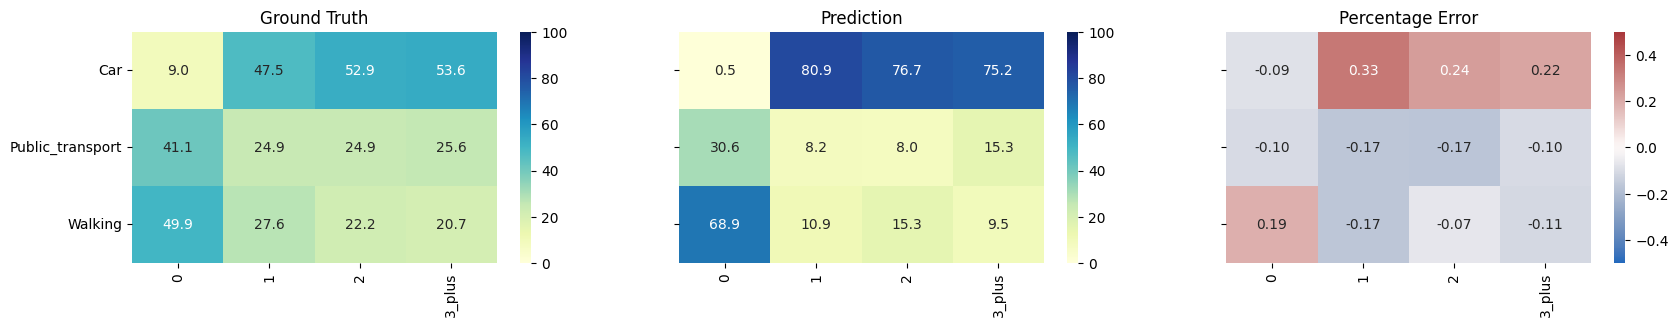

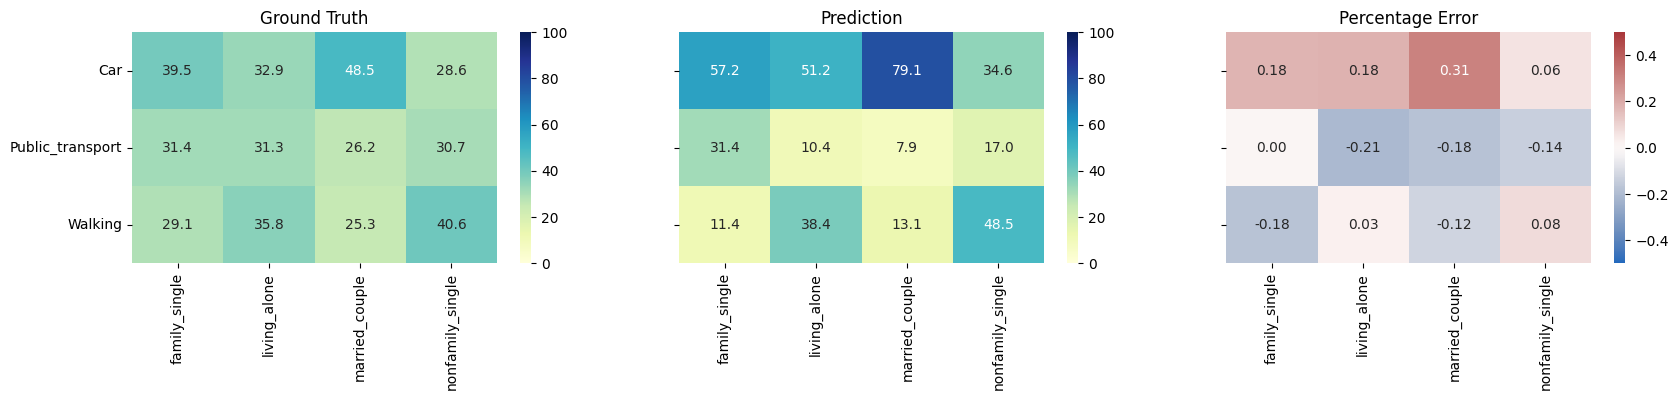

CCE LOSS: 0.9936633174039331
MAPE: 0.15031035143944954
KL Divergence: 0.15848484393784323


In [6]:
from baseline.models.random_forest import RandomForest

num_sample = 10000

model = RandomForest(data_dir='baseline/data',
                     desire=desire, sample_num=num_sample, seed=seed)
train_dataset, test_dataset, mapping = model.load_dataset()
model.train_dataset = train_dataset[train_dataset['age_group'] != 'Teen']
model.test_dataset = test_dataset[test_dataset['age_group'] != 'Teen']
model.prepare_data(choice_type)
model.optimize()
model.train()
loss, error, kl_divergence = model.evaluate_with_cv(
    choice_type, figsize=(20, 3), plot=True)

print('CCE LOSS:', loss)
print('MAPE:', error['mean'])
print('KL Divergence:', kl_divergence['mean'])

# XGBoost


In [7]:
from baseline.models.xgboost import XGBoost


model_name = 'xgboost'

xgb_df = run_baseline_mode(model_name, XGBoost)
xgb_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/kai/anaconda3/envs/pytorch/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 10%|█         | 1/10 [00:05<00:53,  5.99s/it]/Users/kai/anaconda3/envs/pytorch/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 20%|██        | 2/10 [00:15<01:06,  8.30s/it]/Users/kai/anaconda3/envs/pytorch/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 30%|███       | 3/10 [00:28<01:10, 10.10s/it]/Users/kai/ana

,model_name,desire,num_sample,loss,age_group_error,income_group_error,household_size_error,vehicles_error,family_structure_error,mean_error,age_group_kl,income_group_kl,household_size_kl,vehicles_kl,family_structure_kl,mean_kl,best_params
0,xgboost,Eat,2000,1.082494,0.176234,0.188730,0.140028,0.192427,0.150983,0.169680,0.215080,0.283306,0.132163,0.362461,0.161573,0.230917,"{'gamma': 0.1, 'learning_rate': 0.001, 'max_de..."
1,xgboost,Eat,4000,1.082903,0.106097,0.105292,0.085243,0.108363,0.090475,0.099094,0.090551,0.083800,0.042102,0.468558,0.047958,0.146594,"{'gamma': 0.2, 'learning_rate': 0.001, 'max_de..."
2,xgboost,Eat,6000,1.082784,0.122177,0.115647,0.091138,0.109157,0.107348,0.109093,0.100615,0.089197,0.059108,0.489612,0.069570,0.161620,"{'gamma': 0.2, 'learning_rate': 0.001, 'max_de..."
3,xgboost,Eat,8000,1.082603,0.125761,0.112133,0.100860,0.112838,0.105588,0.111436,0.098949,0.082326,0.074752,0.129569,0.069378,0.090995,"{'gamma': 0.2, 'learning_rate': 0.001, 'max_de..."
4,xgboost,Eat,10000,1.082566,0.130431,0.116394,0.095520,0.127852,0.113673,0.116774,0.113380,0.092724,0.067996,0.505614,0.086419,0.173226,"{'gamma': 0.2, 'learning_rate': 0.001, 'max_de..."


/Users/kai/anaconda3/envs/pytorch/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


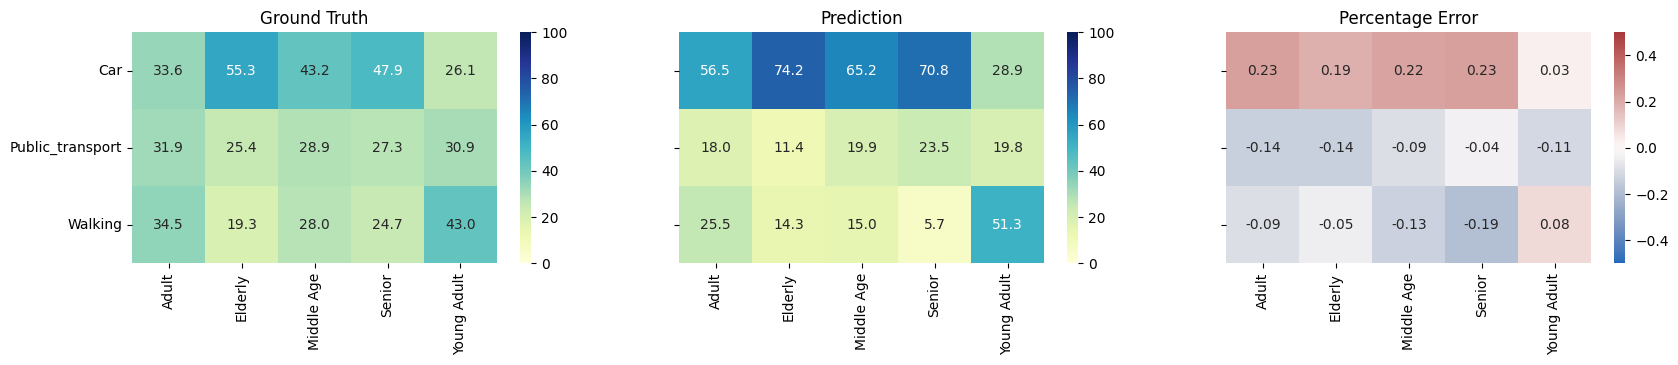

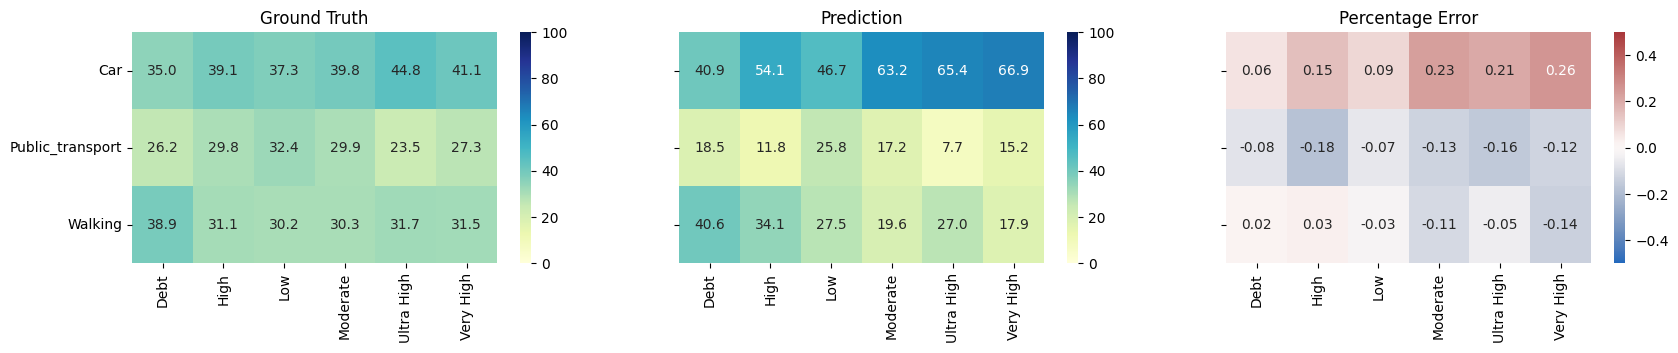

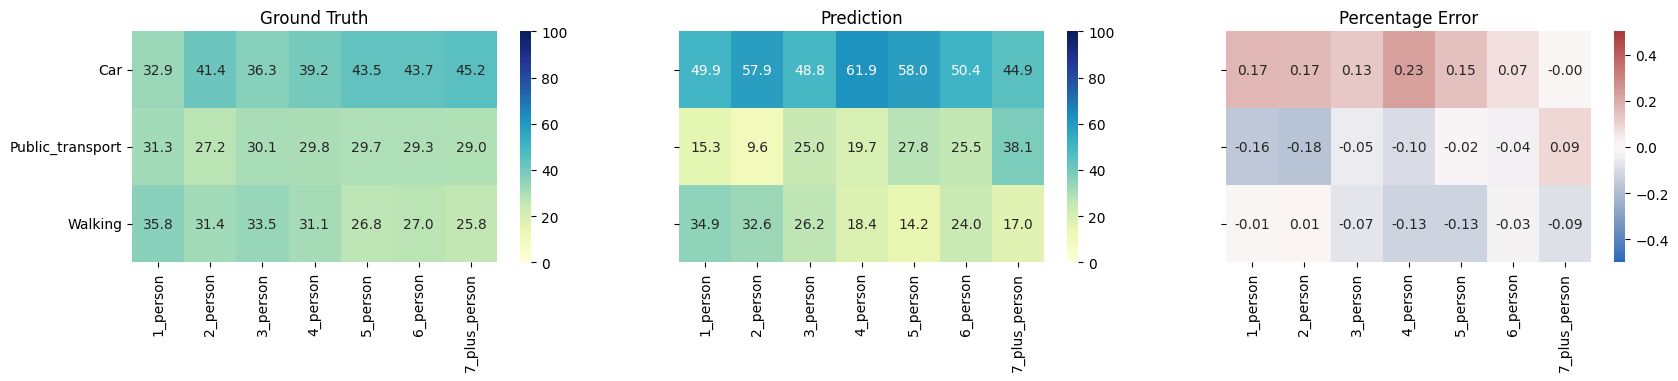

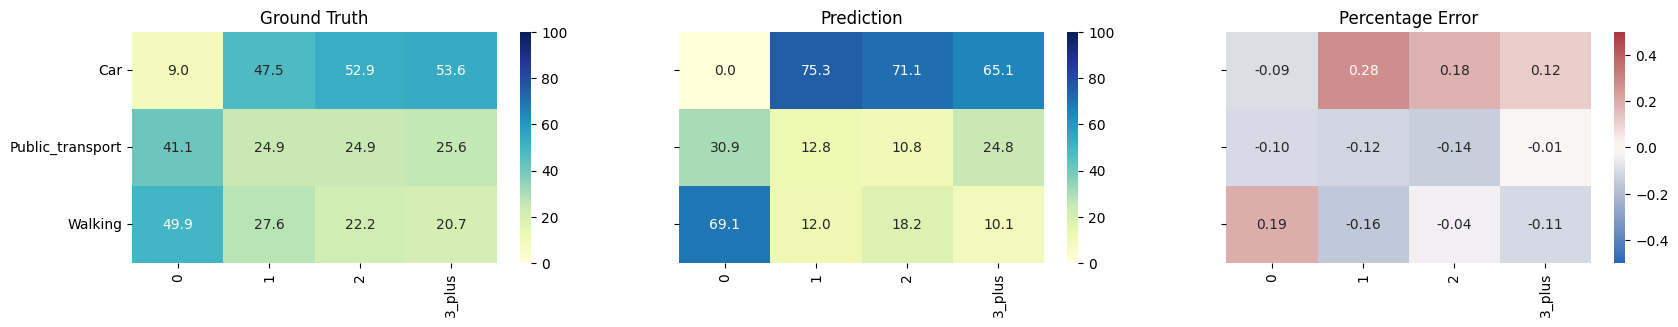

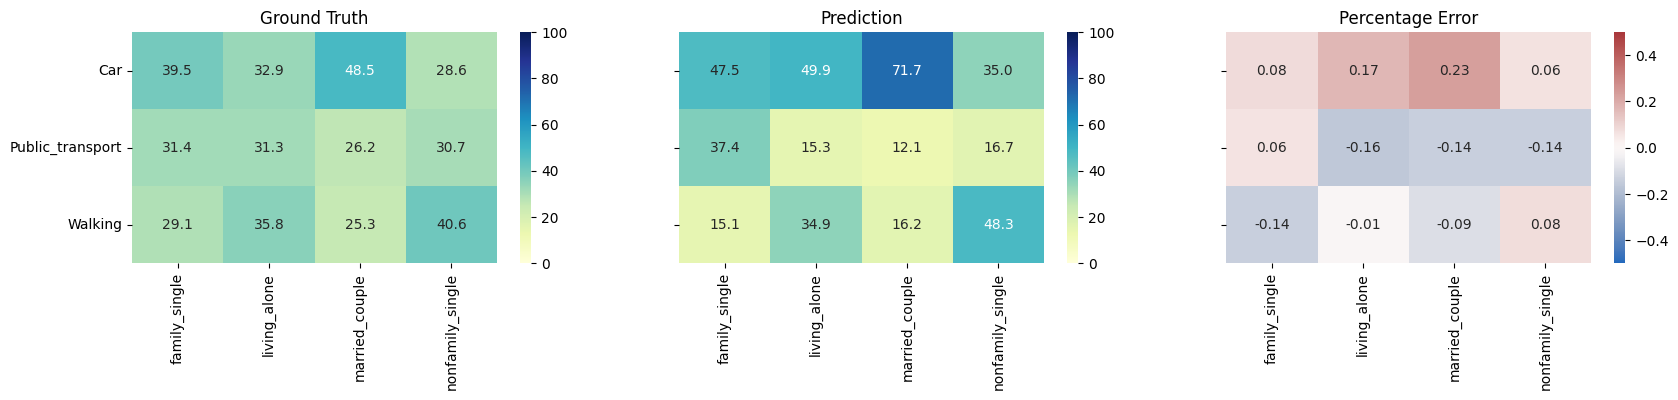

CCE LOSS: 1.0825655771704683
MAPE: 0.11677400629500197
KL Divergence: 0.17322641182302548


In [8]:
from baseline.models.xgboost import XGBoost

num_sample = 10000

model = XGBoost(data_dir='baseline/data',
                desire=desire, sample_num=num_sample, seed=seed)
train_dataset, test_dataset, mapping = model.load_dataset()
model.train_dataset = train_dataset[train_dataset['age_group'] != 'Teen']
model.test_dataset = test_dataset[test_dataset['age_group'] != 'Teen']
model.prepare_data(choice_type)
model.optimize()
model.train()
loss, error, kl_divergence = model.evaluate_with_cv(
    choice_type, figsize=(20, 3), plot=True)

print('CCE LOSS:', loss)
print('MAPE:', error['mean'])
print('KL Divergence:', kl_divergence['mean'])

# Multilayer Perceptron


In [9]:
from baseline.models.multilayer_perceptron import MLP

model_name = 'multilayer_perceptron'

mlp_df = run_baseline_mode(model_name, MLP)
mlp_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/kai/anaconda3/envs/pytorch/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 10/10 [51:09<00:00, 306.99s/it]


,model_name,desire,num_sample,loss,age_group_error,income_group_error,household_size_error,vehicles_error,family_structure_error,mean_error,age_group_kl,income_group_kl,household_size_kl,vehicles_kl,family_structure_kl,mean_kl,best_params
0,multilayer_perceptron,Eat,2000,0.980940,0.191469,0.185237,0.148154,0.199337,0.169221,0.178684,0.254265,0.219471,0.281519,0.693731,0.438121,0.377422,"{'activation': 'tanh', 'alpha': 0.001, 'hidden..."
1,multilayer_perceptron,Eat,4000,0.985008,0.186127,0.192316,0.152151,0.191149,0.155514,0.175451,0.223155,0.330481,0.158682,0.675827,0.191043,0.315838,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
2,multilayer_perceptron,Eat,6000,0.983068,0.208762,0.204209,0.166646,0.203848,0.167190,0.190131,0.284860,0.297695,0.207307,0.889760,0.246891,0.385303,"{'activation': 'relu', 'alpha': 1e-05, 'hidden..."
3,multilayer_perceptron,Eat,8000,0.982652,0.214871,0.200961,0.183676,0.217686,0.173106,0.198060,0.336359,0.286470,0.259988,1.913261,0.215258,0.602267,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
4,multilayer_perceptron,Eat,10000,0.982096,0.219827,0.187362,0.189886,0.227455,0.185264,0.201959,0.431206,0.379388,0.259422,1.989177,0.241884,0.660216,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."


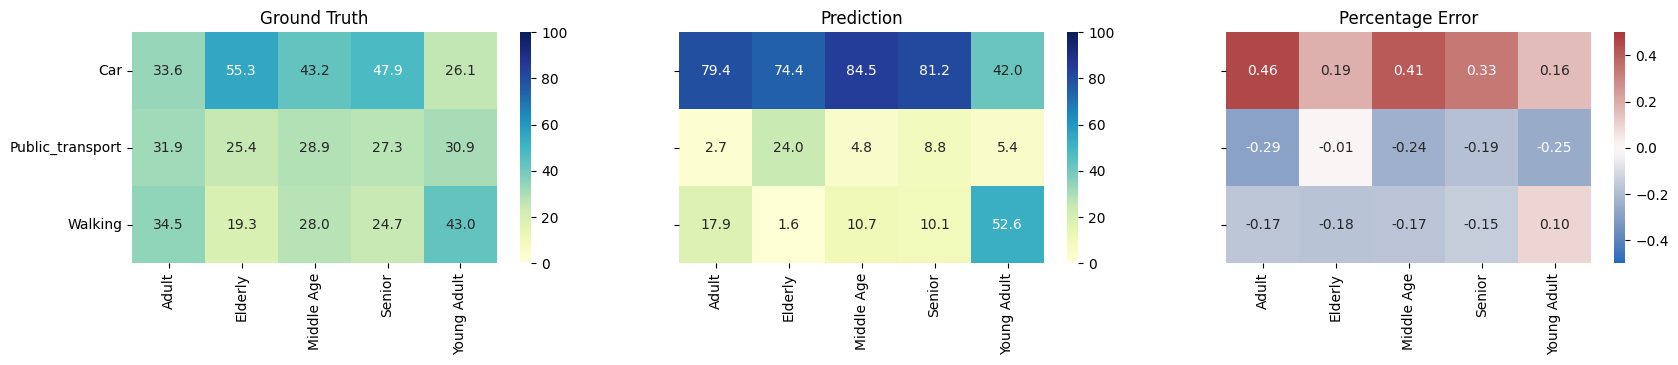

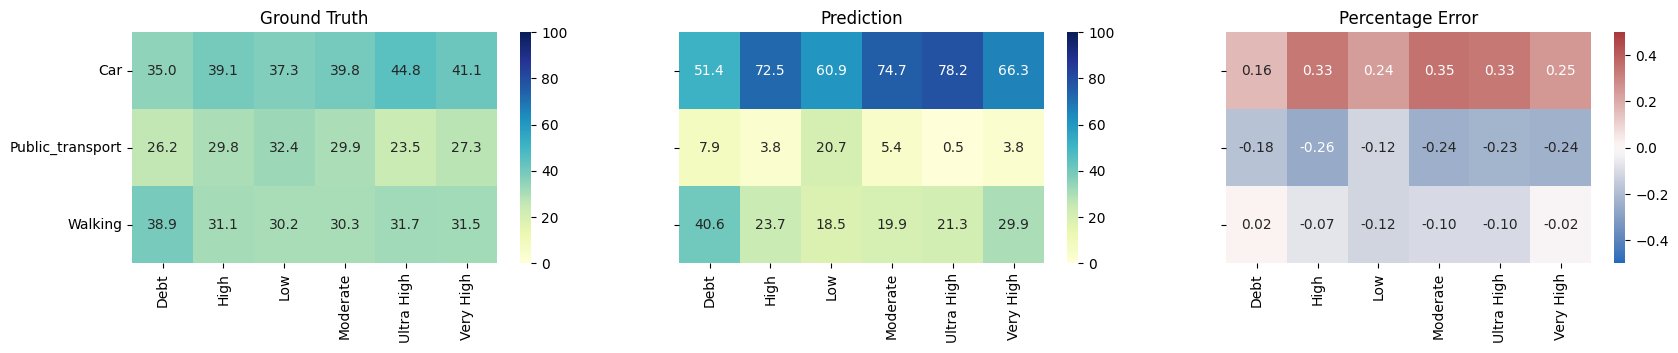

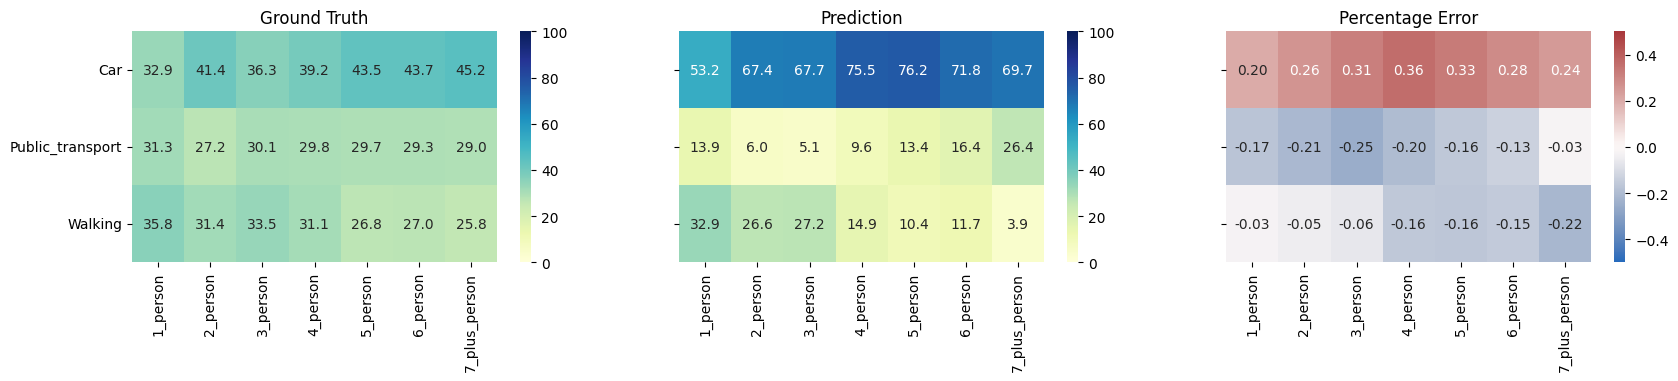

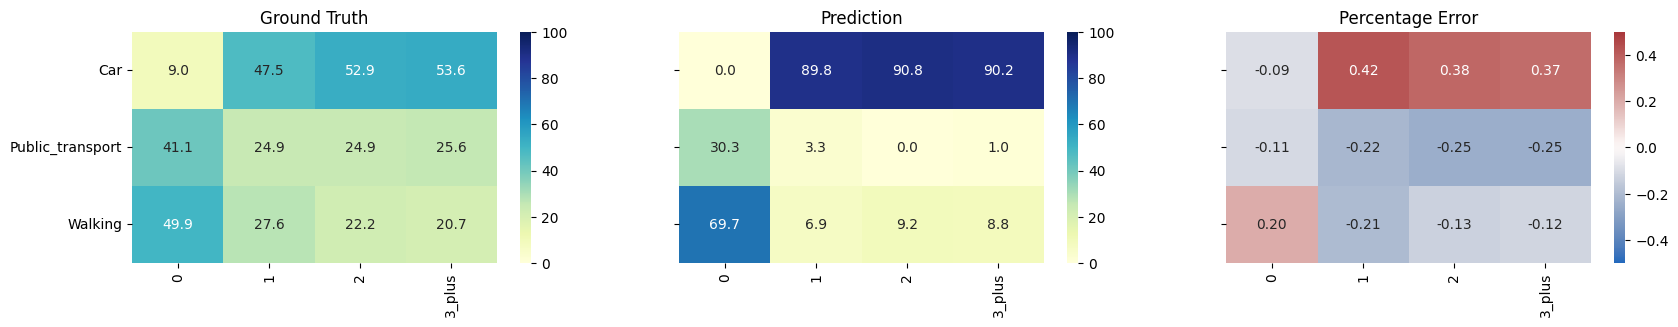

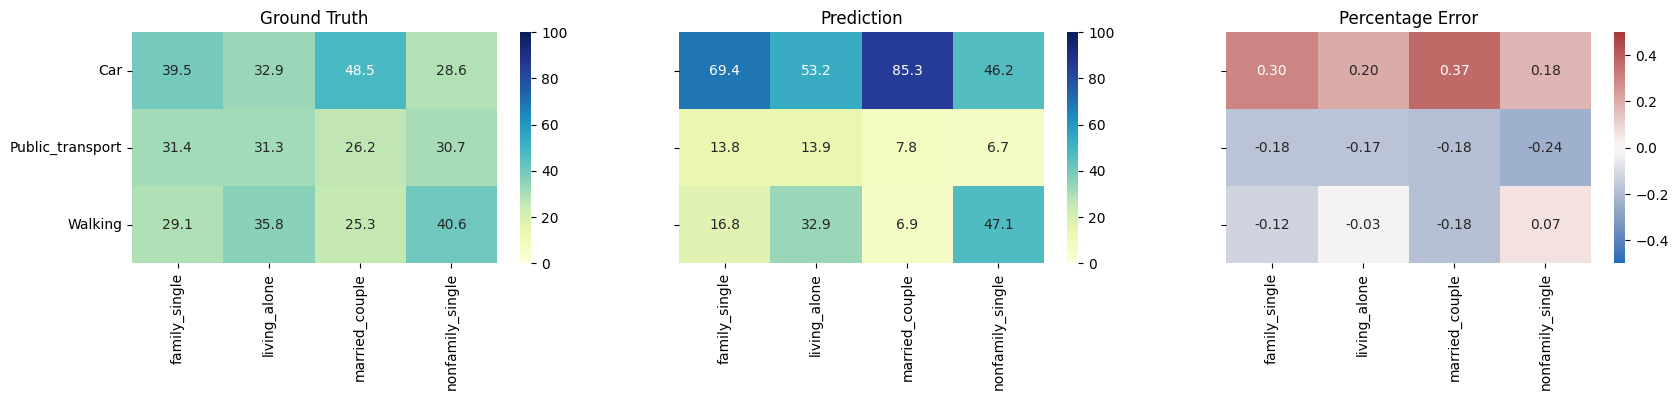

CCE LOSS: 0.9820959281541007
MAPE: 0.20195894310226828
KL Divergence: 0.6602155079726448


In [10]:
from baseline.models.multilayer_perceptron import MLP

num_sample = 10000

model = MLP(data_dir='baseline/data',
            desire=desire, sample_num=num_sample, seed=seed)
train_dataset, test_dataset, mapping = model.load_dataset()
model.train_dataset = train_dataset[train_dataset['age_group'] != 'Teen']
model.test_dataset = test_dataset[test_dataset['age_group'] != 'Teen']
model.prepare_data(choice_type)
model.optimize()
model.train()
loss, error, kl_divergence = model.evaluate_with_cv(
    choice_type, figsize=(20, 3), plot=True)

print('CCE LOSS:', loss)
print('MAPE:', error['mean'])
print('KL Divergence:', kl_divergence['mean'])

# LLM


In [11]:
from model import ChoiceModel

model_name = 'proposed_method'

proposed_df = run_proposed_model(model_name, ChoiceModel)
proposed_df.head()

,model_name,desire,num_sample,loss,age_group_error,income_group_error,household_size_error,vehicles_error,family_structure_error,mean_error,age_group_kl,income_group_kl,household_size_kl,vehicles_kl,family_structure_kl,mean_kl,best_params
0,proposed_method,Eat,0,1.814911,0.152238,0.122835,0.151041,0.115588,0.131655,0.134671,0.151358,0.117253,0.167373,0.083850,0.097282,0.123423,NaN
1,proposed_method,Eat,2000,1.139087,0.074084,0.069664,0.094339,0.069761,0.064609,0.074491,0.039007,0.030807,0.068631,0.027597,0.023674,0.037943,NaN
2,proposed_method,Eat,4000,1.173917,0.067761,0.060415,0.083609,0.047331,0.052637,0.062351,0.025985,0.034460,0.055105,0.017966,0.014589,0.029621,NaN
3,proposed_method,Eat,6000,1.137453,0.079260,0.065917,0.100122,0.087476,0.077018,0.081959,0.038371,0.034556,0.068962,0.041940,0.032983,0.043362,NaN
4,proposed_method,Eat,8000,1.140790,0.071552,0.073040,0.107974,0.061585,0.054424,0.073715,0.035192,0.036994,0.083539,0.023082,0.017248,0.039211,NaN


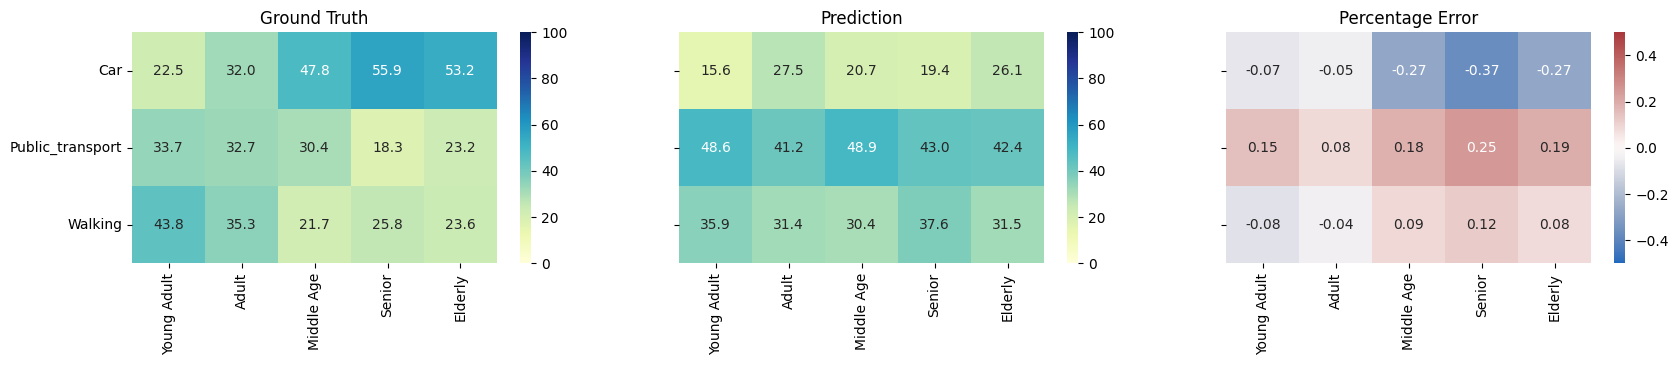

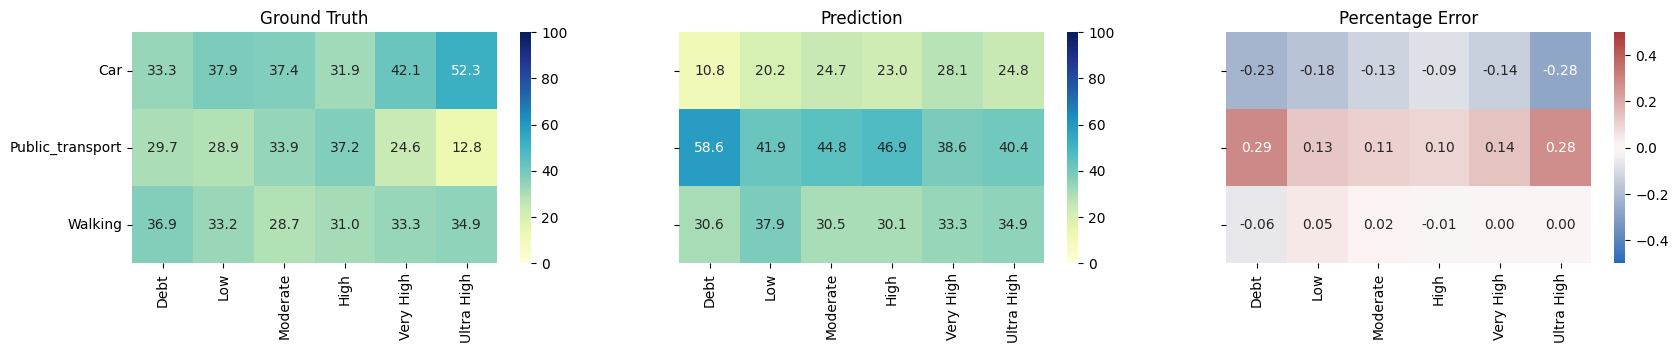

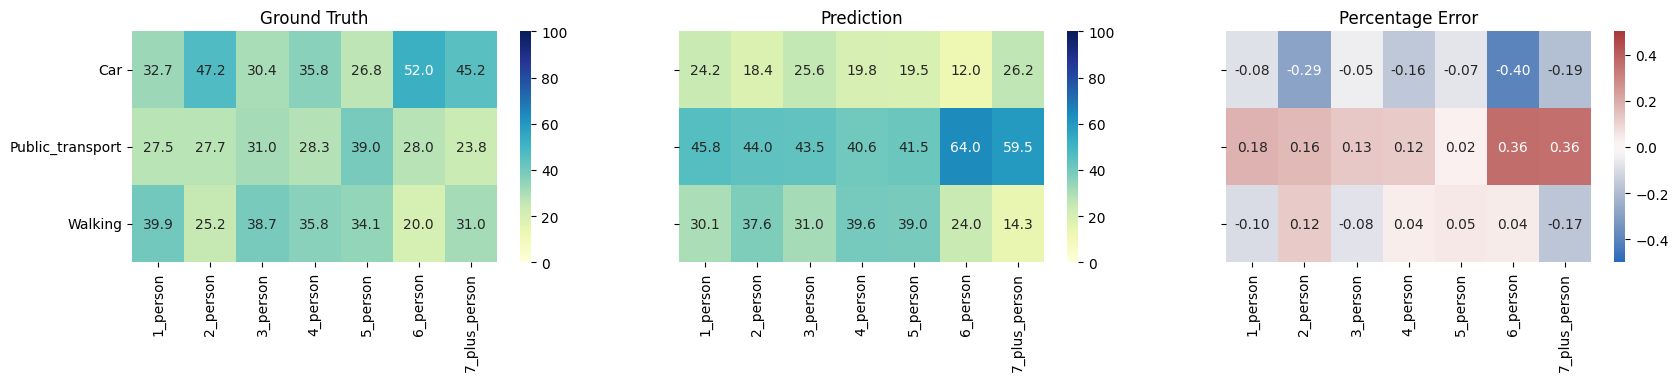

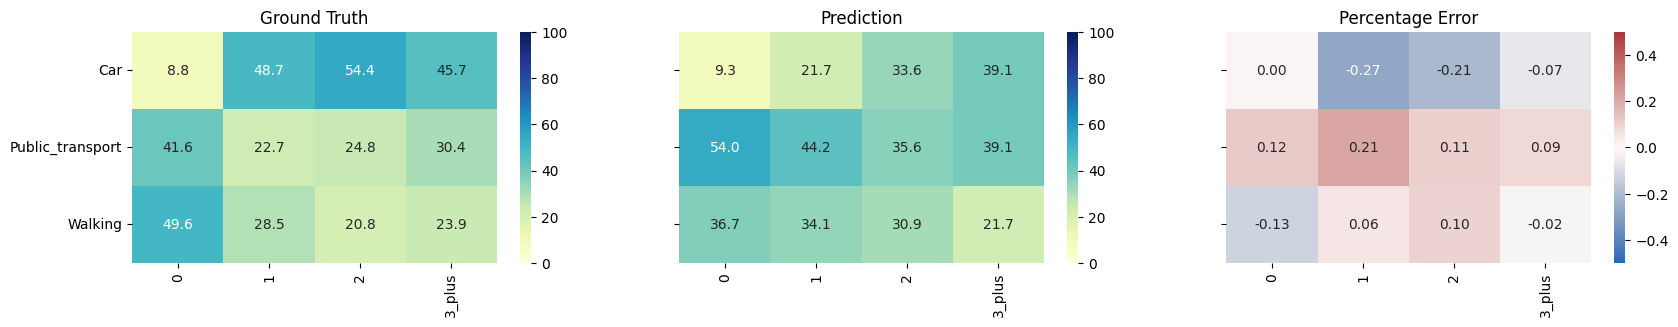

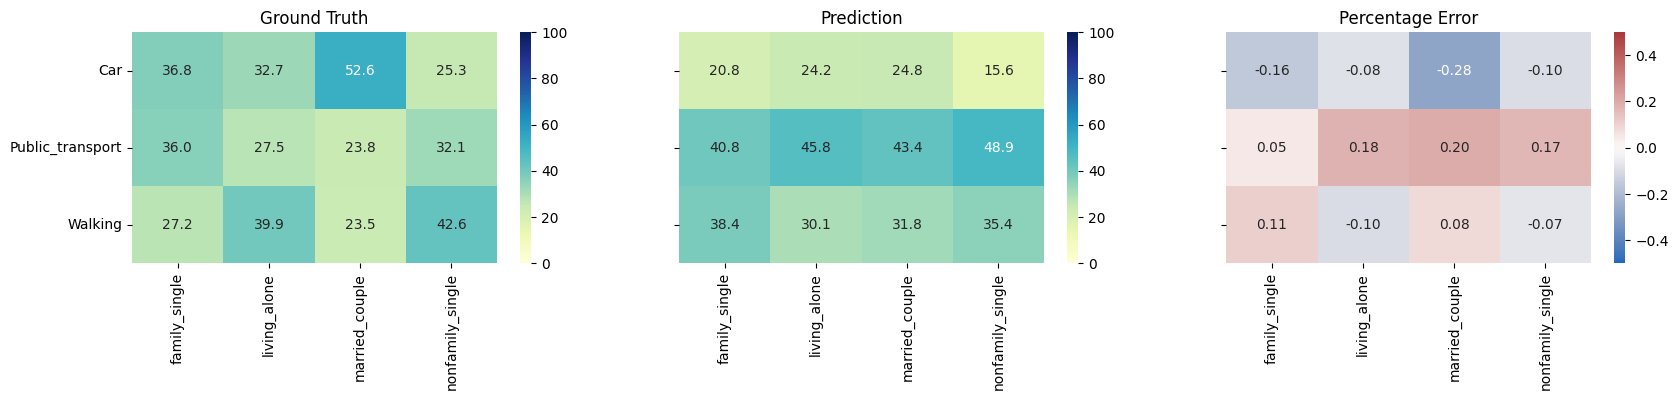

CCE LOSS: 1.8149111291108602
MAPE: 0.13467147777695718
KL Divergence: 0.12342344489417274


In [12]:
from model import ChoiceModel

model_name = 'proposed_method'
num_sample = 0

choice_model = ChoiceModel(
    data_dir='data', desire=desire, sample_num=num_sample, skip_init=True, seed=seed)


log_path = choice_model.log_data_path
test_path = choice_model.test_data_path
data = choice_model._read_log_data(log_path, test_path)
data = data[data['age_group'] != 'Teen']
loss, error, kl_divergence = choice_model._evaluate_with_cv(
    data, choice_type, cv=None, figsize=(20, 3), order=None, plot=True)

print('CCE LOSS:', loss)
print('MAPE:', error['mean'])
print('KL Divergence:', kl_divergence['mean'])

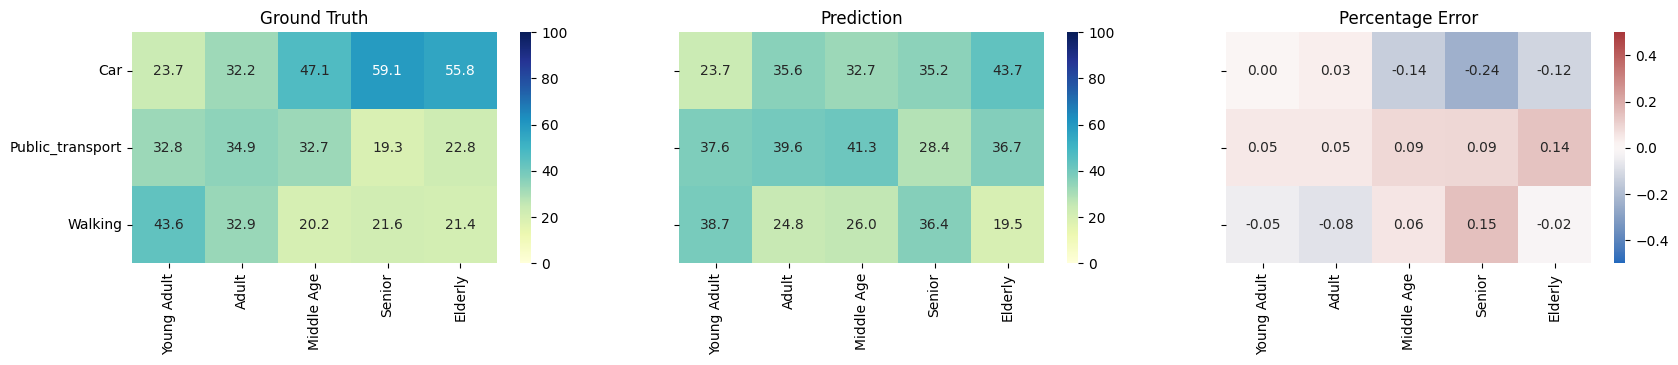

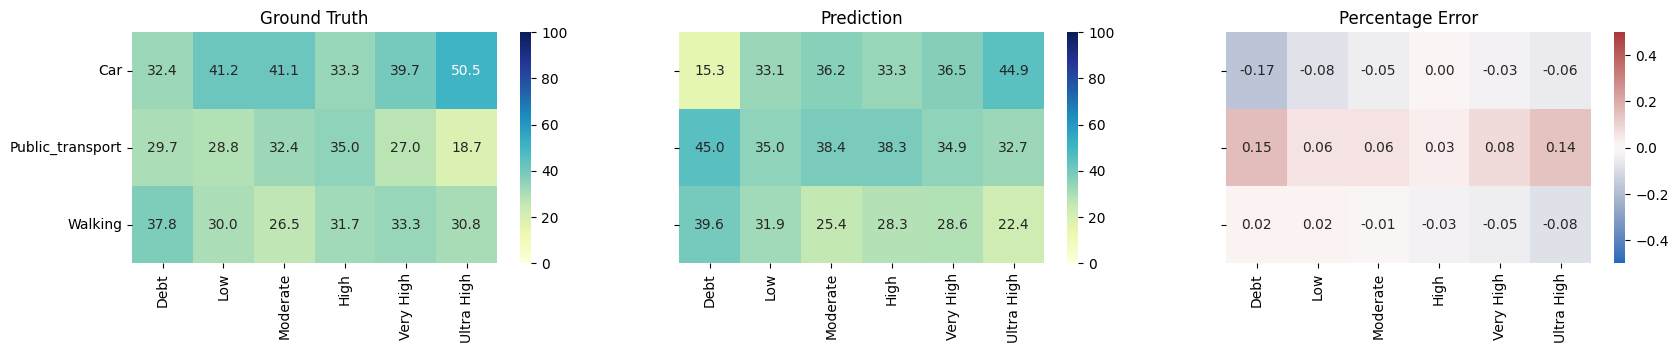

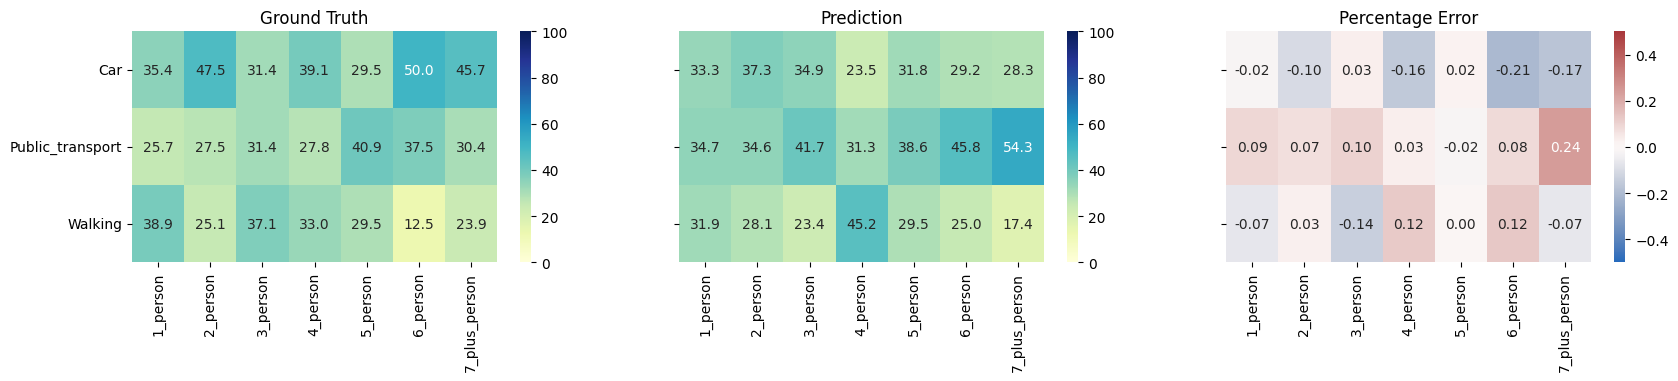

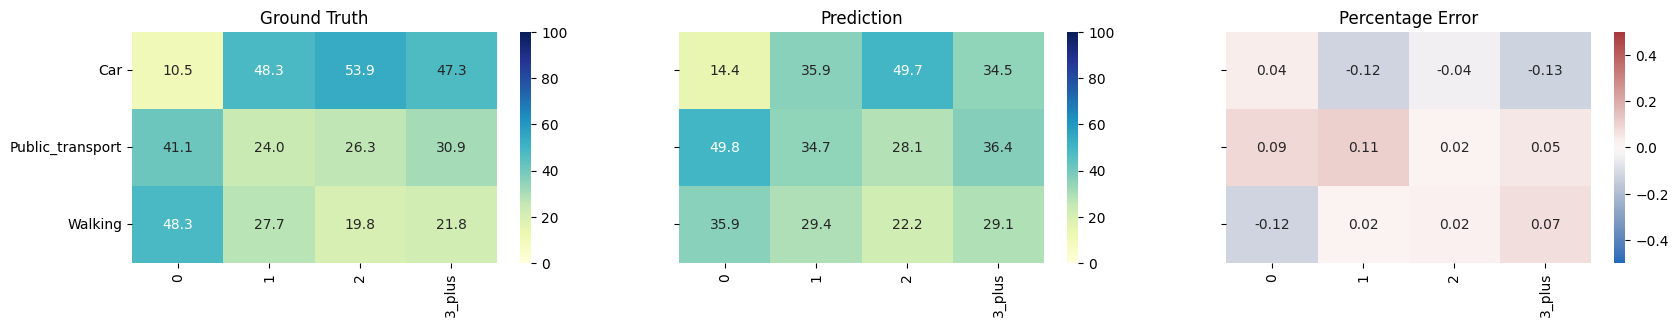

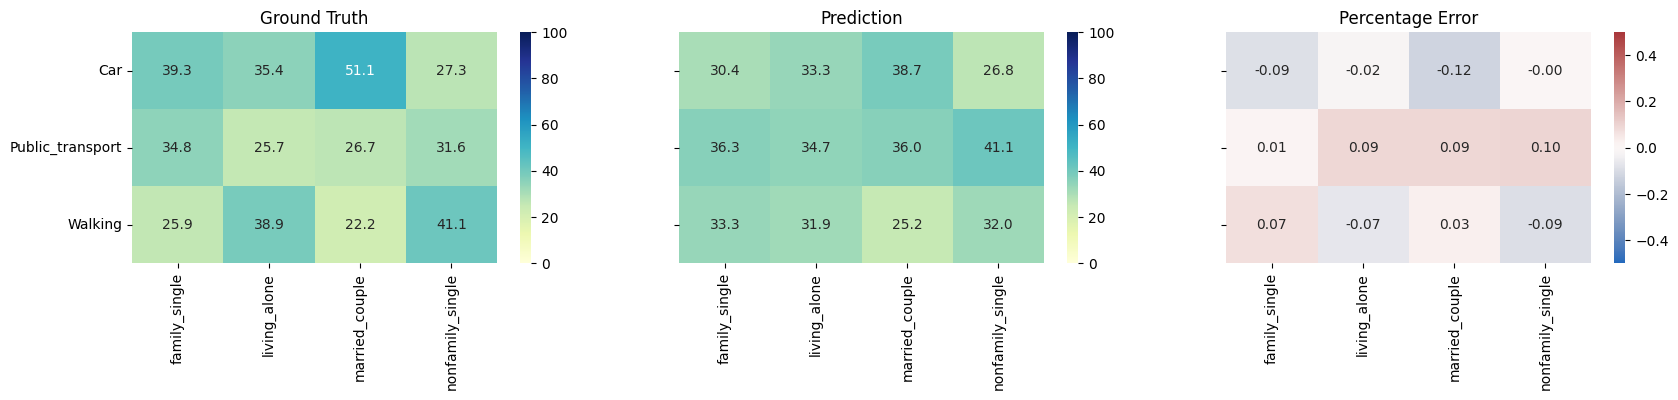

CCE LOSS: 1.085885528888152
MAPE: 0.0753095644511254
KL Divergence: 0.03729023772619933


In [13]:
from model import ChoiceModel

model_name = 'proposed_method'
num_sample = 10000

choice_model = ChoiceModel(
    data_dir='data', desire=desire, sample_num=num_sample, skip_init=True, seed=seed)

log_path = choice_model.log_data_path
test_path = choice_model.test_data_path
data = choice_model._read_log_data(log_path, test_path)
data = data[data['age_group'] != 'Teen']
loss, error, kl_divergence = choice_model._evaluate_with_cv(
    data, choice_type, cv=None, figsize=(20, 3), order=None, plot=True)

print('CCE LOSS:', loss)
print('MAPE:', error['mean'])
print('KL Divergence:', kl_divergence['mean'])

# Results


In [14]:
expeiment_data = pd.concat(
    [rf_df, xgb_df, mlp_df, proposed_df], ignore_index=True)
expeiment_data.head()
experiment_path = 'data/experiments/experiments_01.csv'
expeiment_data.to_csv(experiment_path, index=False)

In [15]:
# experiment_path = 'data/experiments/experiments_01.csv'
# expeiment_data = pd.read_csv(experiment_path)

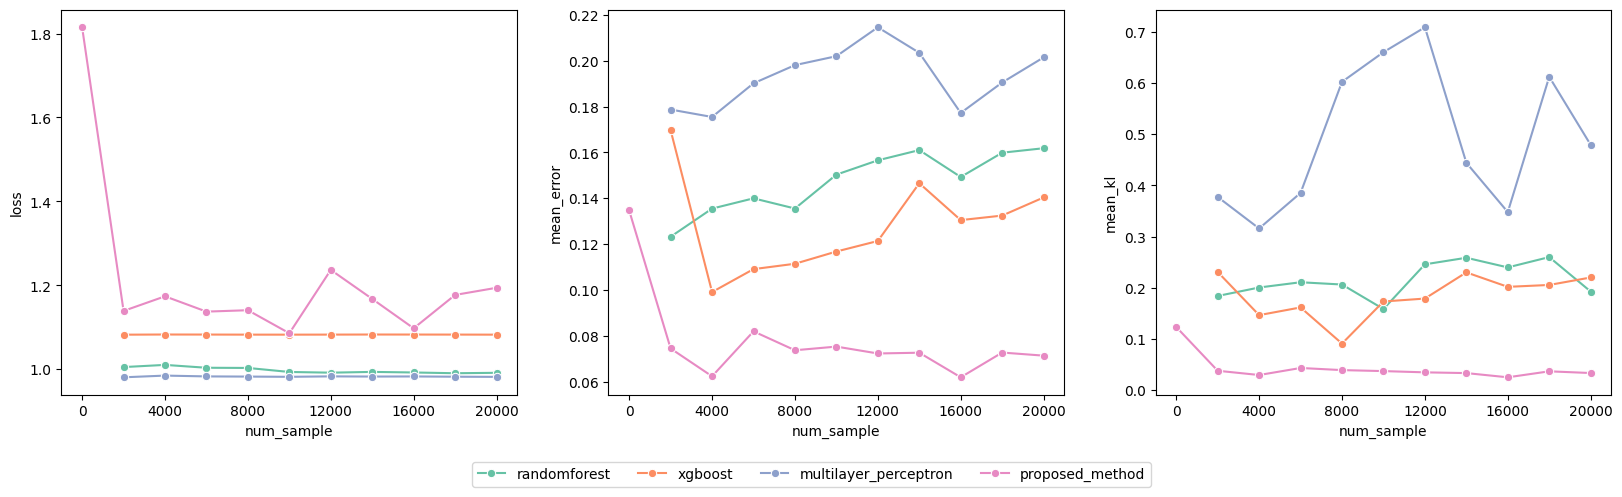

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

plot_data = expeiment_data

color_palette = "Set2"

line1 = sns.lineplot(data=plot_data, x='num_sample', hue='model_name', marker='o',
                     y='loss', ax=axs[0], palette=sns.color_palette(color_palette)[:len(plot_data['model_name'].unique())])

line2 = sns.lineplot(data=plot_data, x='num_sample', hue='model_name', marker='o',
                     y='mean_error', ax=axs[1], palette=sns.color_palette(color_palette)[:len(plot_data['model_name'].unique())])

line3 = sns.lineplot(data=plot_data, x='num_sample', hue='model_name', marker='o',
                     y='mean_kl', ax=axs[2], palette=sns.color_palette(color_palette)[:len(plot_data['model_name'].unique())])


handles, labels = line1.get_legend_handles_labels()

# Turn off individual legends
for ax in axs:
    ax.set_xticks(range(0, 22000, 4000))
    ax.legend().remove()

# Add a single legend
fig.legend(handles, labels, loc='upper center',
           ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.show()

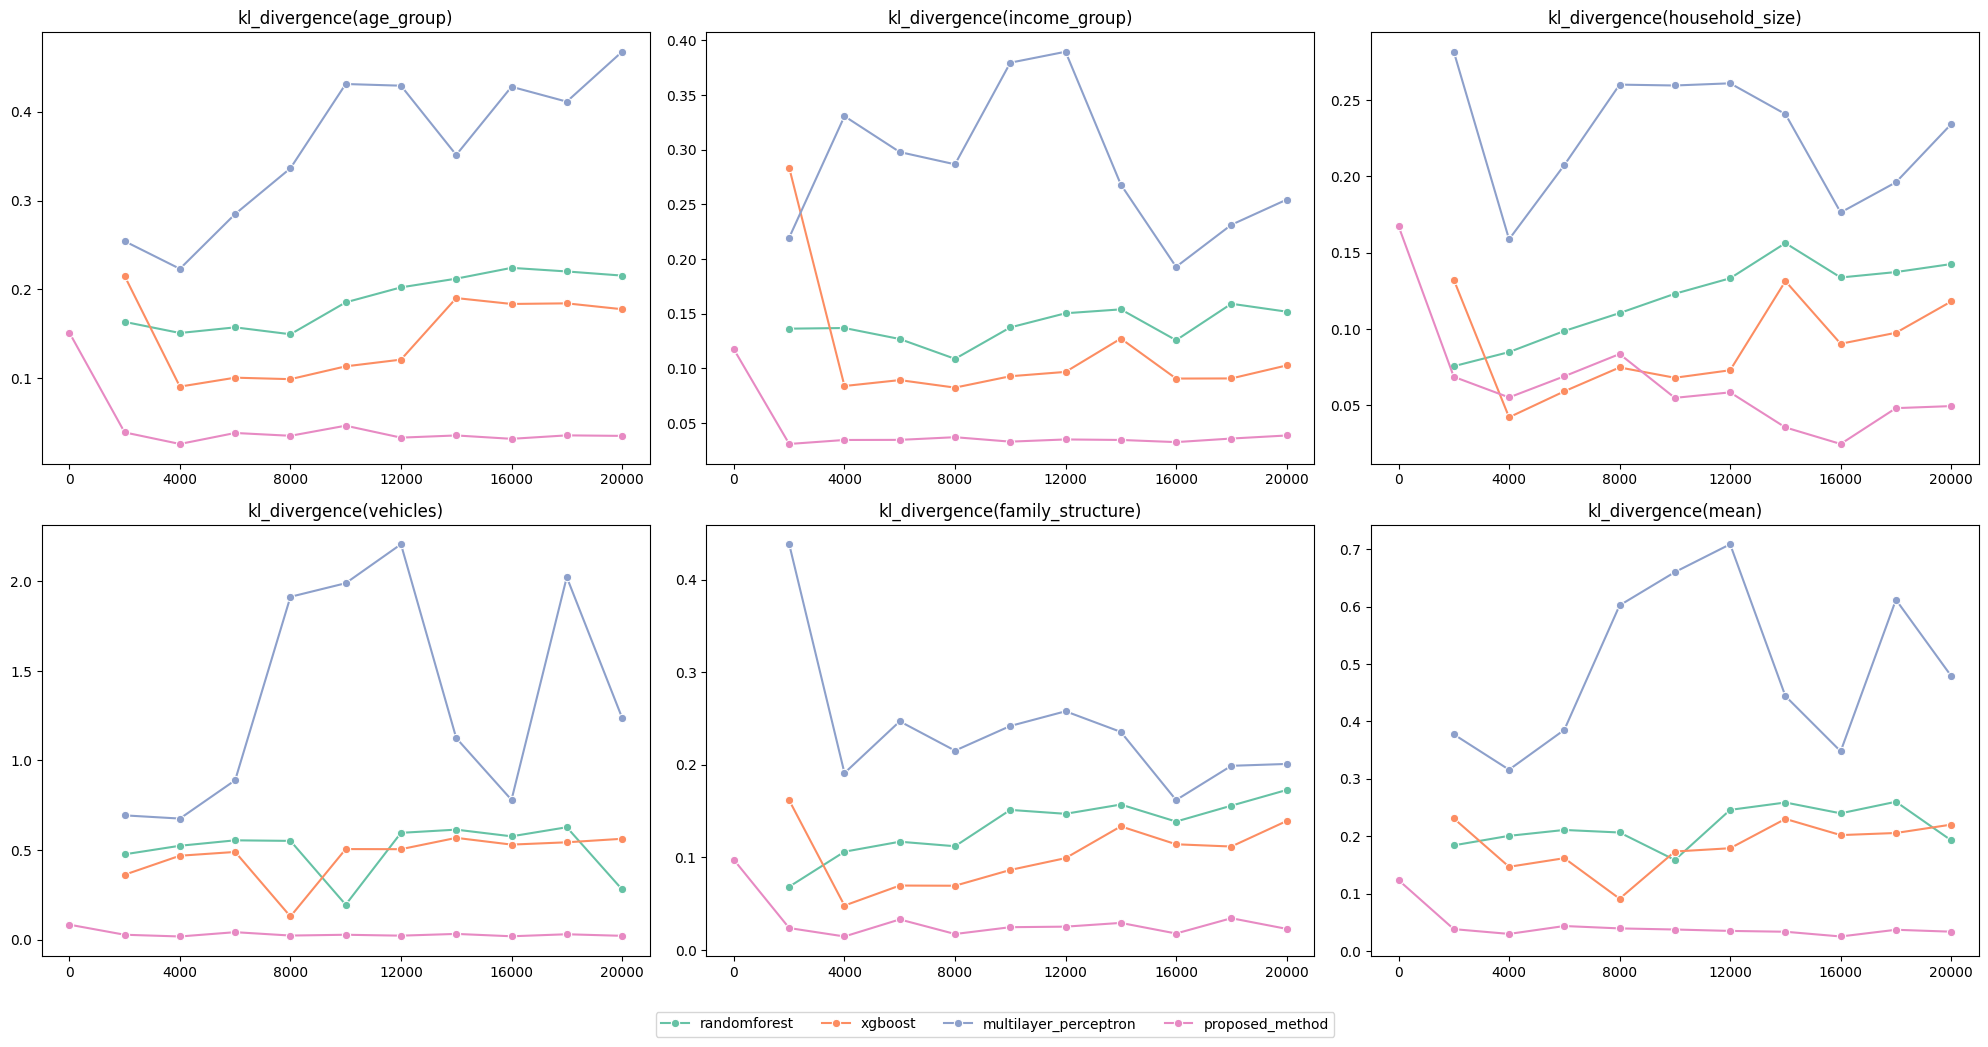

In [17]:
plot_data = expeiment_data

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs = axs.flatten()

for idx, key in enumerate(['age_group', 'income_group', 'household_size', 'vehicles', 'family_structure', 'mean']):
    col_name = key + '_kl'
    line = sns.lineplot(data=plot_data, x='num_sample', hue='model_name', marker='o',
                        y=col_name, ax=axs[idx], palette=sns.color_palette(color_palette)[:len(plot_data['model_name'].unique())])
    axs[idx].set_title(f'kl_divergence({key})')
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')
    axs[idx].set_xticks(range(0, 22000, 4000))
    axs[idx].legend().remove()


handles, labels = line.get_legend_handles_labels()

# Add a single legend
fig.legend(handles, labels, loc='upper center',
           ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()
plt.show()

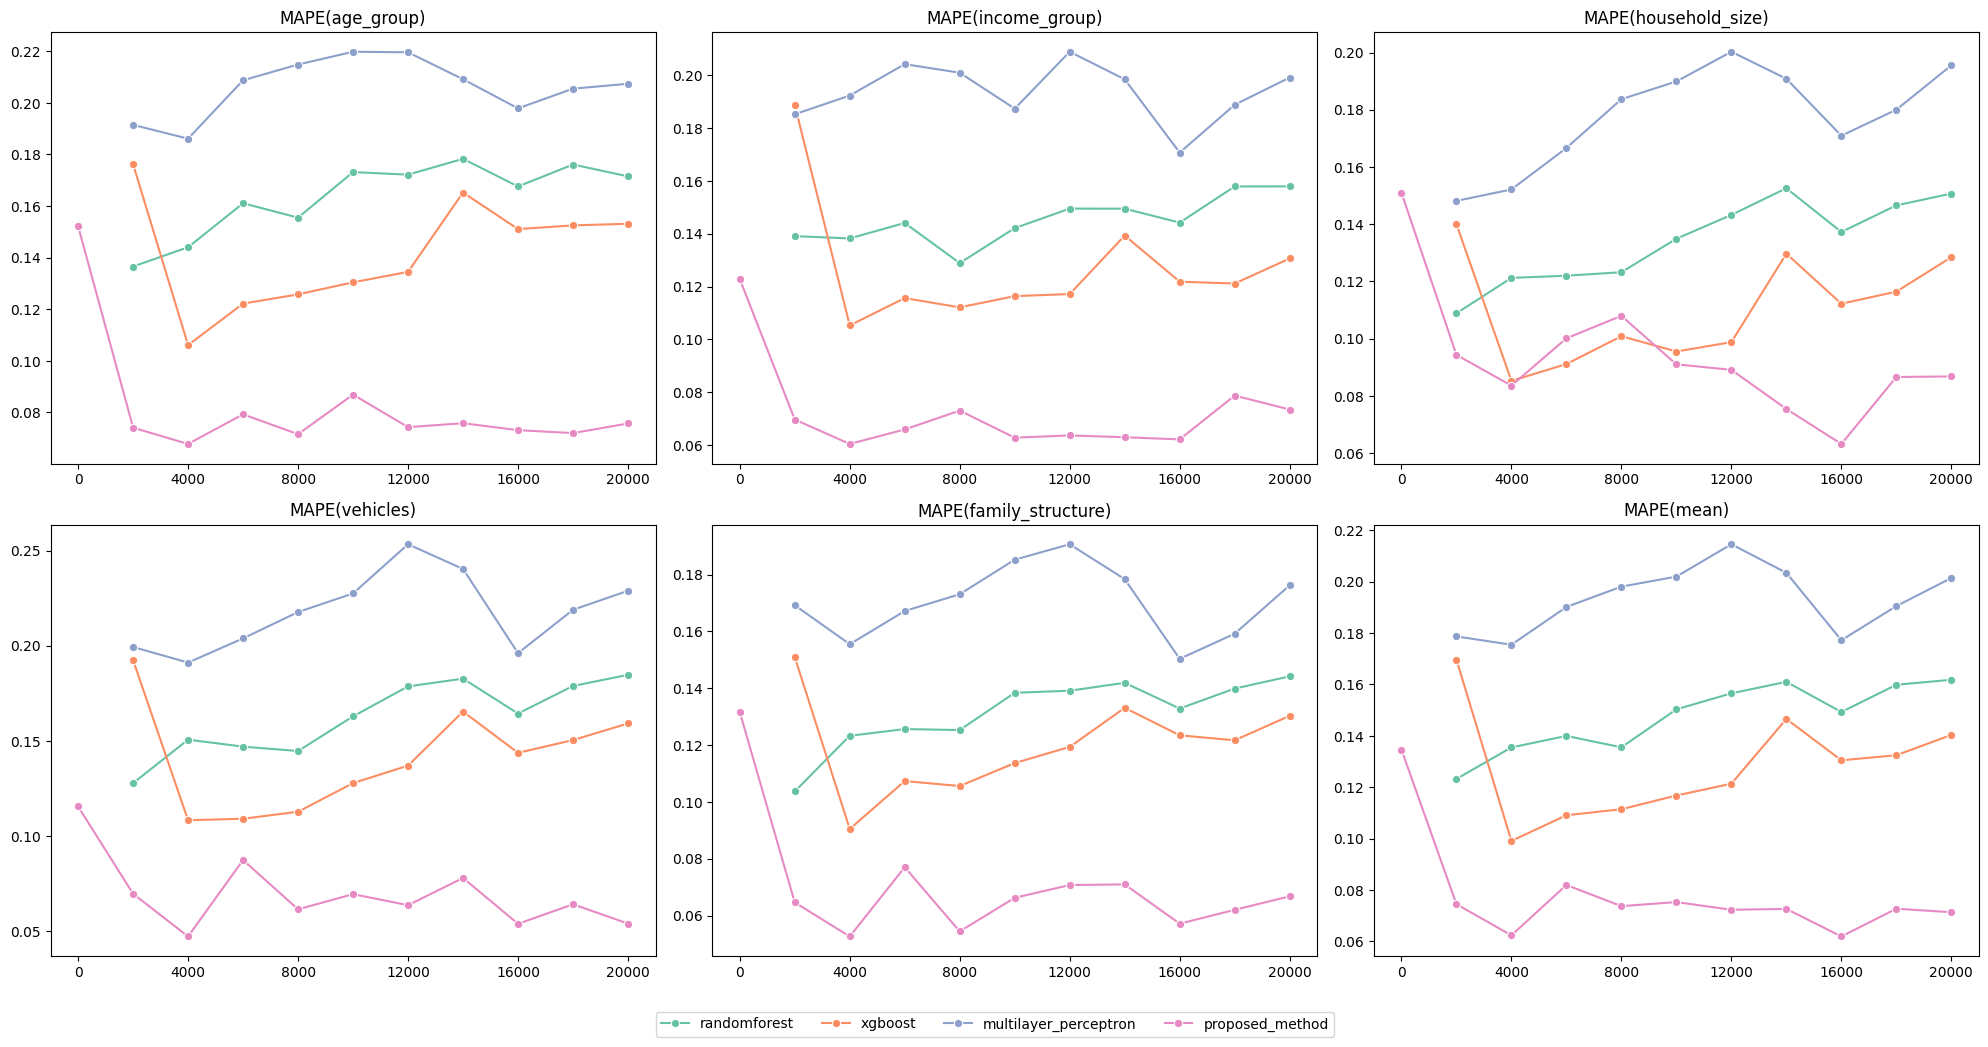

In [18]:
plot_data = expeiment_data

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs = axs.flatten()

for idx, key in enumerate(['age_group', 'income_group', 'household_size', 'vehicles', 'family_structure', 'mean']):
    col_name = key + '_error'
    line = sns.lineplot(data=plot_data, x='num_sample', hue='model_name', marker='o',
                        y=col_name, ax=axs[idx], palette=sns.color_palette(color_palette)[:len(plot_data['model_name'].unique())])
    axs[idx].set_title(f'MAPE({key})')
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')
    axs[idx].set_xticks(range(0, 22000, 4000))
    axs[idx].legend().remove()


handles, labels = line.get_legend_handles_labels()

# Add a single legend
fig.legend(handles, labels, loc='upper center',
           ncol=len(labels), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()
plt.show()